In [17]:
import os
import sys

import numpy as np
import math
import numpy.linalg as LA
import numpy.matlib
from numpy.linalg import norm
import pandas as pd
import utils.wbpdn_lcurve as lc
import matplotlib.pylab as plt
from matplotlib import rc
rc('font', **{'family':'Times', 'size':13})
# rc('text', usetex=True)
rc('savefig', **{'transparent':False})


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from scipy.integrate import odeint
from sklearn.preprocessing import PolynomialFeatures
from scipy.linalg import lstsq

# ####### SPGL1 package #######
# from spgl1 import spg_bpdn
# # from spgl1.lsqr import lsqr
# # from spgl1 import spgl1, spg_lasso, spg_bp, spg_bpdn, spg_mmv
# # from spgl1.spgl1 import norm_l1nn_primal, norm_l1nn_dual, norm_l1nn_project
# # from spgl1.spgl1 import norm_l12nn_primal, norm_l12nn_dual, norm_l12nn_project

import cvxpy as cp

class Obj():
	def __init__(self):
		return

class FOLDER():
	def __init__(self):
		self.data = './data/duffing/'

		# self.post = './postprocessing/'
		# self.ex = './example/'

	def MakeDir(self):
		for k in self.__dict__.keys():
			myfile = self.__dict__[k]
			if isinstance(myfile, str) == True:
				if not os.path.exists(myfile):
					os.makedirs(myfile)

Folder = FOLDER()
Folder.MakeDir()

In [18]:
#####################################################################################
##### Dynamic systems
#####################################################################################
def duffing(x, t, gamma, kappa, epsilon):
	### Compute dynamics
	dsdt = [x[1], -gamma*x[1] - kappa*x[0] - epsilon*x[0]**3.]
	return dsdt

#####################################################################################
##### Parameters 
#####################################################################################
gamma = 0.1
kappa = 1.
epsilon = 5.
poly_order = 3  ##1, x, y, x^2, xy, y^2, x^3, x^2y, xy^2, y^3

x_initial = [0., 1.]
noise_scale = 0.1 ## constant to adjust the error scale 

t0, tf = 0, 2  # start and end
uniform_dt = 'yes'

In [19]:
#####################################################################################
##### Make true & noisy data using a dynamic model 
#####################################################################################
DATA = {}

##### Time instants 
if uniform_dt == 'yes':
	dt = 0.01  # time step
	Nt = int(np.floor(tf-t0)/dt + 1) #Number of time instances
	t_span = np.linspace(t0, tf, Nt)
else:
	Nt = 1000 ##the number of time instants
	t_span = np.sort(np.random.uniform(t0, tf, Nt)) ##Choose random time instants 

dt = np.diff(t_span) ##time step 
DATA['t'] = t_span
nsample = DATA['t'].shape[0]

##### Initial Conditions/Values
DATA['x:init'] =np.array(x_initial)
n_var = len(DATA['x:init'])

##### True data from a dynamic model
DATA['x:true'] = odeint(lambda x, t:duffing(x, t, gamma, kappa, epsilon), DATA['x:init'], t_span)
assert(DATA['x:true'].shape[1] == n_var)

##### True dx solutions in time 
DATA['dx:true'] = np.zeros(DATA['x:true'].shape)
for i in range(nsample):
	DATA['dx:true'][i] = duffing(DATA['x:true'][i], t_span[i], gamma, kappa, epsilon)
assert(np.sum(abs(DATA['x:true'][:,1] - DATA['dx:true'][:,0])) == 0.)

##### Corrupt states by adding noise --> Observation model x_noise(t) = x_true(t) + e(t)
Noise = {}
Noise['true'] = noise_scale*np.random.randn(Nt, n_var) ## Additive zero-mean white noise (Assumed Gaussian)
ti = 0
Noise['true'][ti] = 0.  ## Assume there is no noise at the initial time ti=0

DATA['x:noisy'] = DATA['x:true'] + Noise['true'] ## Add noise to the true data 

In [20]:
#####################################################################################
##### Algorithms
#####################################################################################

##### Subtract assumed(=initialized) noise from observations (= the first approximation for x_true)
DATA['x:approx'] = DATA['x:noisy']

##### Generate multi-variate Vandermonde matrix of degree poly_order in n variables
Poly = PolynomialFeatures(degree=poly_order)
Phi = {}
for i in ['true', 'approx']:
	Phi[i] = Poly.fit_transform(DATA['x:' + i])
P = Phi['approx'].shape[1] ## Number of basis functions
assert(P == math.factorial(poly_order+n_var)/math.factorial(poly_order)/math.factorial(n_var))

##### True coefficients
Coef = {}
Coef['true'] = np.zeros((P, n_var))
Coef['true'][2,0] = 1
Coef['true'][1,1] = -kappa
Coef['true'][2,1] = -gamma
Coef['true'][6,1] = -epsilon

In [14]:
#####################################################################################
##### Solve Equations for Coefficients (integral formulation with iterative denoising)
#####################################################################################
error = {}

##### Generate LHS and integral matrix of the integral formulation using simple quadrature
Xb_Xa = DATA['x:approx'] - np.matlib.repmat(DATA['x:init'], nsample, 1)# LHS
dt_mat = np.tile(dt.reshape(-1,1), (1, P)) ### Reshape for convenience

ninteg = nsample  ##the number of integrations "int_a^b phi_i(x) dt" = the number of (aj, bj) instants
if ((uniform_dt == 'yes') & (dt[0] == 0.0001)):
	Int_Phi = np.loadtxt('./data/Int_Phi_dt0.0001.txt')
else:
	Int_Phi = np.zeros((ninteg, P))
	for i in range(ninteg):
		Int_Phi[i] = np.sum(dt_mat[0:i]*Phi['approx'][0:i], axis=0)

##### Solve the coefficient with a regularized least-square problem 
##### "min 1/2|b - A*Coef|_2^2 + lambda * |Coef|_1"
num_itrs = 3
num_witrs = 3
q = 2
eps_w = 0.0001

Coef['bpdn'] = np.zeros((P, n_var, num_itrs)) ### basis pursuit denoising (BPDN)
Coef['best'] = np.zeros((P, n_var, num_itrs))

error_xapprox = np.zeros((num_itrs,n_var))
error_coef = np.zeros((num_itrs,n_var))
filtered_data = np.zeros((nsample,n_var,num_itrs))

n_lambdas = 100
residuals = np.zeros((n_lambdas, n_var, num_itrs))
reg_residuals = np.zeros((n_lambdas, n_var, num_itrs))
residual_lc = np.zeros((n_var, num_itrs))
reg_residual_lc = np.zeros((n_var, num_itrs))
min_res = np.zeros((n_var, num_itrs))
min_reg_res = np.zeros((n_var, num_itrs))



#Denoising iterations
for itr in range(num_itrs):
    print(f'Iteration {itr}')
    print('----------------------')
    for i in range(n_var):
        
        #Compute error on data
        error_xapprox[itr,i] = norm(DATA['x:approx'][:,i] - DATA['x:true'][:,i]) / norm(DATA['x:true'][:,i])
        filtered_data[:,i,itr] = DATA['x:approx'][:,i]
        print(f'Error filtered data on state {i+1}: '+str(error_xapprox[itr,i]))
        
        b = Xb_Xa[:,i]
        A = Int_Phi
        # Weighted iterations
        for witr in range(num_witrs):  
    
            if witr == 0:
                w = None
            else:
                w = 1 / (np.abs(Coef['bpdn'][:,i, itr]) ** 2 + eps_w)
                
            wbpdn_flc = lc.full_lcurve(A, b, lambda_min = 1e-16, lambda_max = 100, n_lambdas = n_lambdas, normalize = True, plot_lc = False)
            sol_path = wbpdn_flc[0]
            residuals[:,i,itr], reg_residuals[:,i,itr] = wbpdn_flc[1]

            sol_error = np.zeros(sol_path.shape[1])
            for j in range(sol_path.shape[1]):
                sol_error[j] = norm(sol_path[:,j] - Coef['true'][:,i])
            
            min_indx = np.argmin(sol_error)
            Coef['best'][:,i, itr] = sol_path[:,min_indx]
            min_res[i,itr] = residuals[:,i,itr][min_indx]
            min_reg_res[i,itr] = reg_residuals[:,i,itr][min_indx]
        
            wbpdn_c = lc.lcurve_corner(A, b, w=w, lambda_min = 1e-12, lambda_max = 1e3)
            Coef['bpdn'][:,i, itr] = wbpdn_c[0]
#             res_lc, reg_lc = wbpdn_c[3]
#             residual_lc[i,itr] = res_lc[-1]
#             reg_residual_lc[i,itr] = reg_lc[-1]
        
        #Compute error on coefficients
        error_coef[itr,i] = norm(Coef['bpdn'][:,i, itr] - Coef['true'][:,i]) / norm(Coef['true'][:,i])
        print(f'Coefficient error on state {i+1}: '+str(error_coef[itr,i]))
    
    print('\n')
    #Update DATA and LHS
    Xb_Xa = np.dot(Int_Phi, Coef['bpdn'][:,:,itr]) 
    DATA['x:approx'] = DATA['x:init'] + Xb_Xa 
    
    
    #Update int_Phi matrix - Evaluate basis at the denoised states
    Phi['approx'] = Poly.fit_transform(DATA['x:approx'])
    for i in range(ninteg):
        Int_Phi[i] = np.sum(dt_mat[0:i]*Phi['approx'][0:i], axis=0)

Iteration 0
----------------------
Error filtered data on state 1: 0.22685929227815682
Coefficient error on state 1: 0.027963605192328322
Error filtered data on state 2: 0.1399872587069291
Coefficient error on state 2: 11.218087273575318


Iteration 1
----------------------
Error filtered data on state 1: 0.029340900692078068
Coefficient error on state 1: 0.02481723022338478
Error filtered data on state 2: 0.05375608223439932
Coefficient error on state 2: 1.1477548484271933


Iteration 2
----------------------
Error filtered data on state 1: 0.02797910296951878
Coefficient error on state 1: 0.029974727441659188
Error filtered data on state 2: 0.029232862553675826
Coefficient error on state 2: 0.24797026841187234




In [15]:
print(Coef['bpdn'][:,:,1])

[[ 9.93257021e-13 -8.68175159e-16]
 [ 2.22517374e-12 -3.12293526e+00]
 [ 9.75182770e-01 -1.86091126e-14]
 [ 4.19240797e-12  5.40111687e-16]
 [-3.64248794e-12 -3.51228669e-14]
 [ 1.94229121e-12 -4.22237543e-15]
 [ 7.42978530e-12 -1.31294081e-15]
 [-1.35532758e-11 -1.13929927e+00]
 [ 6.43856269e-12  1.85719882e+00]
 [ 7.60681134e-13 -2.22265131e-11]]


findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


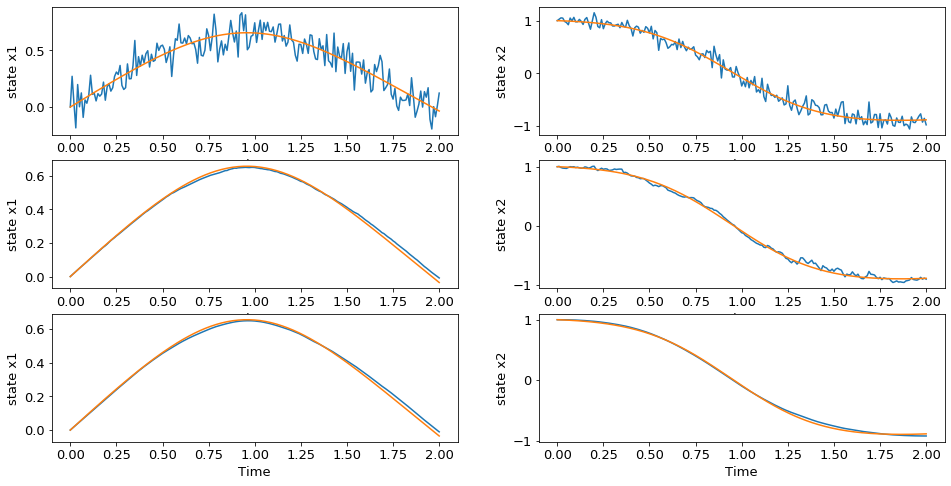

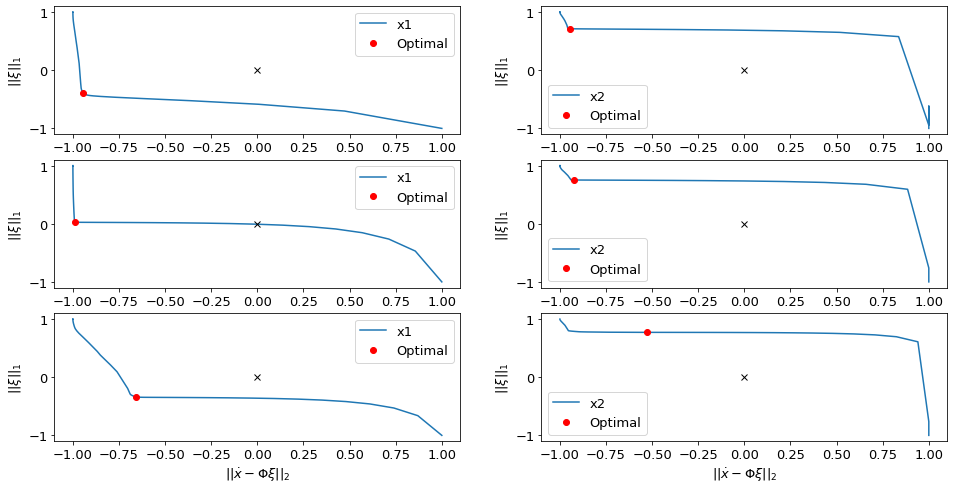

In [16]:
fig, axs = plt.subplots(num_itrs,n_var,figsize = (16,8))

for itr in range(num_itrs):
    for state in range(n_var):
        axs[itr][state].plot(DATA['t'],filtered_data[:,state,itr])
        axs[itr][state].plot(DATA['t'],DATA['x:true'][:,state])
        axs[itr][state].set_xlabel('Time')
        axs[itr][state].set_ylabel(f'state x{state+1}')
        
fig2, axs2 = plt.subplots(num_itrs,n_var,figsize = (16,8))

for itr in range(num_itrs):
    for state in range(n_var): 
        
        axs2[itr][state].plot(residuals[:,state,itr], reg_residuals[:,state,itr])
        axs2[itr][state].plot(min_res[state,itr], min_reg_res[state,itr],'ro')
        axs2[itr][state].plot(residual_lc[state,itr], reg_residual_lc[state,itr],'kx')
        axs2[itr][state].set_xlabel(r'$||\dot{x} - \Phi \xi||_2$')
        axs2[itr][state].set_ylabel(r'$||\xi||_1$')
        axs2[itr][state].legend([f'x{state+1}','Optimal'])

In [54]:
##### Calculate approximation for dx from the coefficients achieved
DATA['dx:bpdn'] = np.zeros(DATA['dx:true'].shape)
for i in range(n_var):
    DATA['dx:bpdn'][:,i] = np.dot(Phi['approx'],  Coef['bpdn'][:,i,-1])

Text(0, 0.5, 'coefficient value')

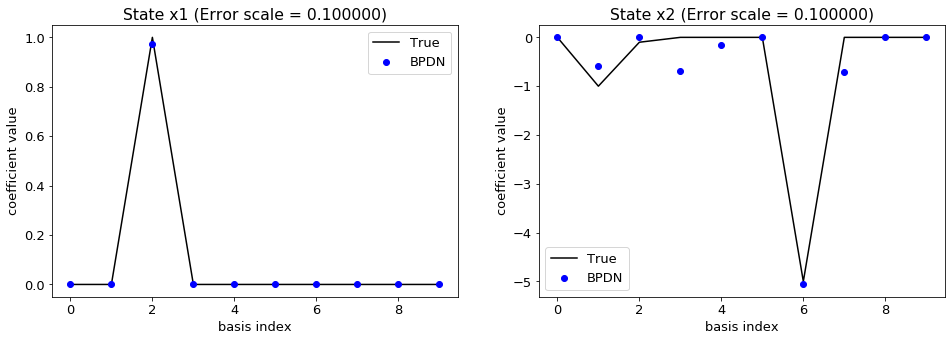

In [55]:
##### Plot: Compare coefficients 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
ax1.plot(Coef['true'][:,0],'k')
ax1.plot(Coef['bpdn'][:,0,-1],'bo')
ax1.legend(('True','BPDN'))
ax1.set_title('State x1 (Error scale = {:f})'.format(noise_scale))
ax1.set_xlabel('basis index')
ax1.set_ylabel('coefficient value')

ax2.plot(Coef['true'][:,1],'k')
ax2.plot(Coef['bpdn'][:,1,-1],'bo')
ax2.legend(('True','BPDN'))
ax2.set_title('State x2 (Error scale = {:f})'.format(noise_scale))
ax2.set_xlabel('basis index')
ax2.set_ylabel('coefficient value')

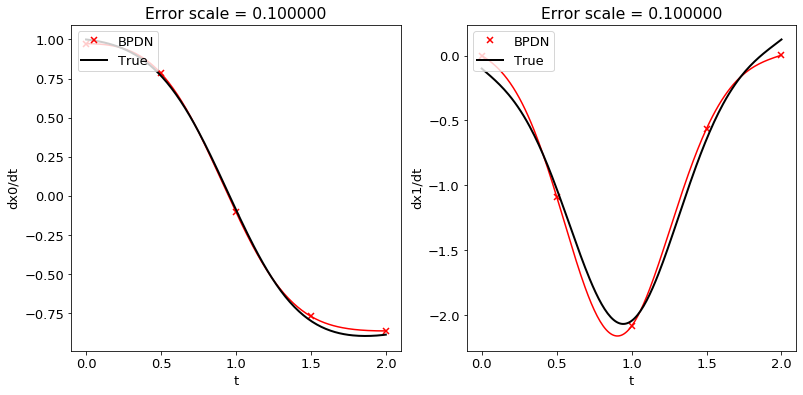

In [56]:
##### Plot: Compare dx/dt solutions from different coefficient solutions
ax = {}
fig, (ax[0], ax[1]) = plt.subplots(1, 2, figsize=(13,6))

for i in range(n_var):
	for method in ['bpdn']:#, 'bpdn']:
		cc = {'bpdn':'r'}[method]
		mk = {'bpdn':'x'}[method]
		ax[i].plot(t_span, DATA['dx:'+method][:,i], cc+'-', lw=1.5)
		jump = 50
		ax[i].plot(t_span[::jump], DATA['dx:'+method][:,i][::jump], cc+mk, label=method.upper(), mew=1.5, mfc='none')
	ax[i].plot(t_span, DATA['dx:true'][:,i], 'k-', label='True', lw=2)

	ax[i].set_xlabel('t')
	ax[i].set_ylabel('dx{:d}/dt'.format(i))
	ax[i].set_title('Error scale = {:f}'.format(noise_scale))
	ax[i].legend(loc='upper left', borderpad=0.3)

plt.show()